Instalujemy wykorzystywane pakiety

In [ ]:
%%capture
!pip install gymnasium==0.27.0
!pip install tqdm
!pip install seaborn
!pip install colab-dev-tools
!pip install numpy
!pip install matplotlib
!pip install gym[box2d]
%matplotlib inline

#Importy

Oto blok kodu w języku Python, który importuje kilka bibliotek: matplotlib, pandas, numpy, gym, torch, torch.nn, torch.nn.functional i torch.optim.

matplotlib to biblioteka do tworzenia wykresów w Pythonie, pandas to biblioteka do analizy danych, numpy to biblioteka do pracy z tablicami, gym to zestaw narzędzi do tworzenia i porównywania algorytmów uczenia ze wzmocnieniem, a torch to biblioteka do uczenia maszynowego, która zapewnia funkcjonalność do budowania sieci neuronowych.

Moduły torch.nn i torch.nn.functional zapewniają narzędzia do budowania sieci neuronowych, a moduł torch.optim zapewnia algorytmy optymalizacji do trenowania sieci neuronowych.

Ogólnie rzecz biorąc, ten kod służy do importowania bibliotek, które będą używane do budowy i trenowania sieci neuronowych oraz tworzenia wykresów.

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Parametry
Ten blok kodu definiuje dwie zmienne.

Pierwsza zmienna DEVICE jest obiektem torch.device, który przechowuje informacje o urządzeniu, na którym będzie wykonywany kod. W tym przypadku, jeśli urządzenie GPU (karta graficzna) jest dostępne, DEVICE ustawia się na "cuda:0", w przeciwnym razie na "cpu".

Druga zmienna PATH to ścieżka do pliku, który zawiera zapisaną wstępnie wytrenowaną sieć neuronową dla zadania środowiska BipedalWalker-v3. Plik ten będzie używany w dalszej części kodu do załadowania sieci neuronowej.

Trzecia zmienna PATH_LOG to ścieżka do pliku, w którym będą zapisywane dzienniki lub logi z działania programu. W tym przypadku plik ten będzie nazwany "log.txt".

In [ ]:
# Select platform for calculations
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Select Path for model and logs
PATH = "/content/drive/MyDrive/ISI/Inteligencja oblizeniowa w analizie danych/preTrained/BipedalWalker-v3"
PATH_LOG =  "log.txt"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Implementacja agenta

Ten blok kodu definiuje klasę Actor, która dziedziczy po klasie nn.Module z biblioteki torch.nn.

W metodzie init tworzona jest sieć neuronowa z trzema warstwami liniowymi. Pierwsza warstwa liniowa (self.l1) przyjmuje rozmiar wejściowy równy state_dim i generuje wyjście o rozmiarze 400. Druga warstwa liniowa (self.l2) przyjmuje wejście o rozmiarze 400 i generuje wyjście o rozmiarze 300. Trzecia warstwa liniowa (self.l3) przyjmuje wejście o rozmiarze 300 i generuje wyjście o rozmiarze action_dim.

W metodzie forward definiowany jest sposób przetwarzania wejścia przez sieć. Wejście (state) jest przekazywane przez kolejno warstwy liniowe, a wynik otrzymany na wyjściu z ostatniej warstwy jest przeskalowany przez max_action (maksymalną wartość akcji). Wynik ten jest następnie przetwarzany przez funkcję tanh z biblioteki torch, co zapewnia, że wartość akcji będzie zawsze w przedziale [-1, 1]. Ostatecznie wynik zwracany jest jako wartość akcji (a).

W ten sposób klasa Actor definiuje architekturę sieci neuronowej, która będzie używana jako aktor w algorytmie uczenia ze wzmocnieniem.

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action
        
    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a

#Implementacja Krytyka
Ten blok kodu definiuje klasę Critic, która dziedziczy po klasie nn.Module z biblioteki torch.nn.

W metodzie init tworzona jest sieć neuronowa z trzema warstwami liniowymi. Pierwsza warstwa liniowa (self.l1) przyjmuje wejście o rozmiarze równym sumie state_dim (rozmiaru stanu) i action_dim (rozmiaru akcji) i generuje wyjście o rozmiarze 400. Druga warstwa liniowa (self.l2) przyjmuje wejście o rozmiarze 400 i generuje wyjście o rozmiarze 300. Trzecia warstwa liniowa (self.l3) przyjmuje wejście o rozmiarze 300 i generuje wyjście o rozmiarze 1, które jest oceną jakości danej pary stan-akcja.

W metodzie forward definiowany jest sposób przetwarzania wejścia przez sieć. Najpierw stan (state) i akcja (action) są łączone w jeden wektor (state_action) za pomocą funkcji torch.cat. Następnie wejście to jest przekazywane przez kolejno warstwy liniowe, a wynik otrzymany na wyjściu z ostatniej warstwy jest zwracany jako ocena jakości danej pary stan-akcja (q).

W ten sposób klasa Critic definiuje architekturę sieci neuronowej, która będzie używana jako krytyk w algorytmie uczenia ze wzmocnieniem.

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)
        
        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q

#Implementacja buffora przechowującego akcje agenta

Ten blok kodu definiuje klasę ReplayBuffer, która służy do przechowywania przejść agenta (stan, akcja, nagroda, następny stan, flaga zakończenia).

W metodzie init inicjowane są atrybuty klasy buffer (lista, która będzie przechowywać przejścia), max_size (maksymalny rozmiar bufora) oraz size (aktualny rozmiar bufora, początkowo ustawiony na 0).

Metoda add służy do dodawania nowego przejścia do bufora. Przyjmuje ona jeden argument transition, który jest krotką zawierającą kolejno stan, akcję, nagrodę, następny stan oraz flagę zakończenia. Metoda ta dodaje przejście do listy buffer oraz zwiększa wartość atrybutu size o 1.

Metoda sample służy do pobierania losowego podzbioru przejść z bufora o zadanej wielkości batch_size. Jeśli rozmiar bufora przekracza maksymalny rozmiar (max_size), to usuwane jest najstarsze 20% przejść. Następnie losowo wybierane są indeksy przejść, a odpowiadające im stany, akcje, nagrody, następne stany oraz flagi zakończenia są pobierane z bufora i zapisywane do pięciu osobnych list (state, action, reward, next_state, done). Na koniec metoda zwraca pięć list zawierających wybrane przejścia.


In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=5e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

#Implementacja algorytmu TD3
Ten kod to implementacja algorytmu Twin Delayed Deep Deterministic Policy Gradient (TD3) w Pythonie. Jest to jeden z najnowocześniejszych algorytmów uczenia ze wzmocnieniem, który wykorzystuje głębokie sieci neuronowe do uczenia się optymalnej polityki sterowania dla agenta w środowisku.

W klasie TD3 zdefiniowano trzy główne komponenty: aktora, krytyka 1 i krytyka 2. Aktor jest siecią neuronową, która otrzymuje stan środowiska i zwraca akcję. Krytyk to również sieć neuronowa, która otrzymuje stan środowiska i akcję, a następnie ocenia ich wartość Q. W TD3 używamy dwóch krytyków, aby zminimalizować błąd oszacowania wartości Q.

W funkcji select_action() korzystamy z naszego aktora, aby wygenerować akcję dla danego stanu. Funkcja update() jest najważniejszą częścią algorytmu TD3 i służy do uczenia sieci neuronowych. W każdym kroku aktualizujemy wagi naszych sieci neuronowych, korzystając z próbek z pamięci powtórkowej.

Algorytm TD3 wykorzystuje także technikę sztucznego szumu, aby zachęcić agenta do eksploracji środowiska. Używamy tu dwa rodzaje szumu: policy_noise i noise_clip. Policy_noise jest dodawane do wyjścia aktora, podczas gdy noise_clip służy do ograniczenia wartości szumu.

W funkcji save() i load() zapisujemy i wczytujemy wagi naszych sieci neuronowych do plików w celu łatwiejszego przenoszenia pomiędzy różnymi środowiskami.

In [ ]:
class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(DEVICE)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(DEVICE)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic_1 = Critic(state_dim, action_dim).to(DEVICE)
        self.critic_1_target = Critic(state_dim, action_dim).to(DEVICE)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_2 = Critic(state_dim, action_dim).to(DEVICE)
        self.critic_2_target = Critic(state_dim, action_dim).to(DEVICE)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(DEVICE)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):
        
        for i in range(n_iter):
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(DEVICE)
            action = torch.FloatTensor(action_).to(DEVICE)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(DEVICE)
            next_state = torch.FloatTensor(next_state).to(DEVICE)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(DEVICE)
            
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(DEVICE)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()
            
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()
            
            if i % policy_delay == 0:
                actor_loss = -self.critic_1(state, self.actor(state)).mean()
                
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                    
                
    def save(self, directory, name):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, name))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target.pth' % (directory, name))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1.pth' % (directory, name))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target.pth' % (directory, name))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2.pth' % (directory, name))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target.pth' % (directory, name))
        
    def load(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
    def load_actor(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))

# Trenowanie
Funkcja train to funkcja, która służy do trenowania algorytmu TD3 (Twin Delayed Deep Deterministic Policy Gradient) w środowisku BipedalWalker-v3.

Kod działa w następujący sposób:

Inicjalizacja hiperparametrów algorytmu (gamma, batch_size, lr, exploration_noise, polyak, policy_noise, noise_clip, policy_delay, max_episodes, max_timesteps).

Tworzenie środowiska OpenAI Gym dla gry BipedalWalker-v3.
Inicjalizacja sieci neuronowych (Q1, Q2 i policy) oraz bufora replay_buffer.
Pętla treningowa dla każdego epizodu:

a. Resetowanie środowiska i pobranie stanu początkowego.
b. Pętla po timesteps:



1.   Wybór akcji przez sieć policy z dodatkiem szumu eksploracyjnego.
2.   Otrzymanie nagrody i nowego stanu po wykonaniu akcji w środowisku.
3. Dodanie do bufora replay_buffer przejścia (state, action, reward, next_state, done).
4. Aktualizacja wartości Q i polityki za pomocą funkcji policy.update().


c. Zapisanie nagrody epizodu w krzywej uczenia curve i w pliku log_f.
W przypadku osiągnięcia nagrody średniej powyżej 300, zapisanie modelu z rozwiązaniem i przerwanie treningu.
W przypadku wykonania więcej niż 5000 epizodów, zapisanie modelu i kontynuowanie treningu.
Co log_interval epizodów, wyświetlenie średniej nagrody dla danego epizodu.

In [ ]:
curve = list()
def train(set_gamma):

    ######### Hyperparameters #########
    log_interval = 25           # print avg reward after interval
    random_seed = 0
    gamma = set_gamma               # discount for future rewards
    batch_size = 100            # num of transitions sampled from replay buffer
    lr = 0.001
    exploration_noise = 0.1 
    polyak = 0.995              # target policy update parameter (1-tau)
    policy_noise = 0.2          # target policy smoothing noise
    noise_clip = 0.5
    policy_delay = 2            # delayed policy updates parameter
    max_episodes = 1000        # max num of episodes
    max_timesteps = 2000        # max timesteps in one episode
    ###################################

    env_name = "BipedalWalker-v3"
    filename = "TD3_{}_{}".format(env_name, random_seed)
    directory = PATH
    
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    policy = TD3(lr, state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer()
    
    if random_seed:
        print("Random Seed: {}".format(random_seed))
        env.seed(random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
    
    avg_reward = 0
    ep_reward = 0
    log_f = open(PATH_LOG,"w+")
    
    for episode in range(1, max_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            action = policy.select_action(state)
            action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
            action = action.clip(env.action_space.low, env.action_space.high)
            
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state
            
            avg_reward += reward
            ep_reward += reward
            
            if done or t==(max_timesteps-1):
                policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
                break
        
        curve.append(ep_reward)
        
        log_f.write('{},{}\n'.format(episode, ep_reward))
        log_f.flush()
        ep_reward = 0

        if (avg_reward/log_interval) >= 300:
            print("########## Solved! ###########")
            name = filename + '_solved'
            policy.save(directory, name)
            log_f.close()
            break
        if episode > 5000:
            policy.save(directory, filename)
        
        if episode % log_interval == 0:
            avg_reward = int(avg_reward / log_interval)
            print("Episode: {}\tAverage Reward: {}".format(episode, avg_reward))
            avg_reward = 0


In [ ]:
#train(0.81)

In [ ]:
train(0.999)

Episode: 25	Average Reward: -115
Episode: 50	Average Reward: -114
Episode: 75	Average Reward: -111
Episode: 100	Average Reward: -114
Episode: 125	Average Reward: -113
Episode: 150	Average Reward: -116
Episode: 175	Average Reward: -78
Episode: 200	Average Reward: -19
Episode: 225	Average Reward: 23
Episode: 250	Average Reward: 152
Episode: 275	Average Reward: 158
Episode: 300	Average Reward: 211
Episode: 325	Average Reward: 202
Episode: 350	Average Reward: 221
Episode: 375	Average Reward: 227
Episode: 400	Average Reward: 229


KeyboardInterrupt: ignored

In [ ]:
#train(0.9)

# Testowanie
Funkcja test() służy do przetestowania wytrenowanej sieci TD3 (tzw. Twin Delayed Deep Deterministic Policy Gradient) na środowisku BipedalWalker-v3 z biblioteki OpenAI Gym.

Funkcja ta najpierw inicjuje środowisko oraz wczytuje wytrenowaną sieć z pliku zapisanego wcześniej przez funkcję train(). Następnie, przez określoną liczbę epizodów, testuje sieć poprzez przeprowadzenie symulacji w środowisku.

W każdym epizodzie, agent podejmuje akcje na podstawie obserwacji stanu, otrzymuje nagrodę za daną akcję, a stan środowiska przechodzi do kolejnego kroku czasowym, aż do osiągnięcia maksymalnej liczby kroków lub końca epizodu. Funkcja test() zbiera wyniki każdego epizodu, a na końcu wyświetla nagrody dla każdego epizodu.

In [ ]:
def test():
    env_name = "BipedalWalker-v3"
    random_seed = 0
    n_episodes = 300
    lr = 0.002
    max_timesteps = 2000
    render = True
    save_gif = False
    
    filename = "TD3_{}_{}".format(env_name, random_seed)
    filename += '_solved'
    directory = PATH + env_name
    
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    policy = TD3(lr, state_dim, action_dim, max_action)
    
    policy.load_actor(directory, filename)
    
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state = env.reset()
        for t in range(max_timesteps):
            action = policy.select_action(state)
            state, reward, done, _ = env.step(action)
            ep_reward += reward
            if done:
                break
            
        print('Episode: {}\tReward: {}'.format(ep, int(ep_reward)))
        ep_reward = 0
        env.close()        

In [ ]:
test()

# Wizualizacja
Ten kod służy do wizualizacji wyników trenowania algorytmu TD3 na środowisku BipedalWalker-v3.

Pierwsza linijka kodu oblicza kroczącą średnią nagród dla krzywej wyników, korzystając z biblioteki pandas.

Następnie wizualizujemy krzywą wyników i jej kroczącą średnią na wykresie za pomocą biblioteki matplotlib. Oś X przedstawia liczbę epizodów, a oś Y nagrodę uzyskaną w każdym epizodzie.

Krzywa "Original Curve" przedstawia wyniki uzyskane podczas treningu, a krzywa "Average" przedstawia kroczącą średnią wyników dla każdych dziesięciu kolejnych epizodów.

Na końcu dodajemy etykiety osi i legendę wykresu, a następnie wyświetlamy wykres.

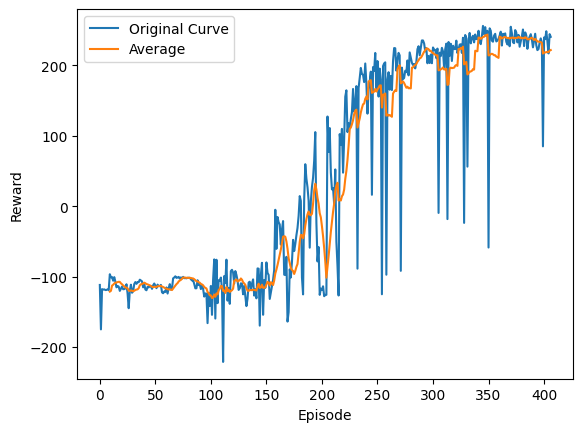

In [ ]:
# Plot of reward over time + rolling avarage of reward 
rolling_mean = pd.Series(curve).rolling(10).mean()

plt.plot(list(range(len(curve))), curve, label='Original Curve')
plt.plot(list(range(len(rolling_mean))), rolling_mean, label='Average')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

#Porównanie różnych współczynników dyskontowych

Sprawdziliśmy współczynniki gamma 0.9, 0.99 i 0.999. Im wyższy współczynnik, tym szybciej algorytm się uczył. Przy współczynniku 0.999 prawie za każdym razem model szybko uzyskiwał satysfakcjonujące wyniki. Przy 0.99 czasami udało mu się nauczyć, a czasami nie. Przy współczynniku równym 0.9 nie udało nam się wytrenować naszego modelu.

#Wnioski

W naszej grze BipedalWalker zastosowaliśmy algorytm TD3, który doś dobrze radzi sobie z wyrenowaniem agenta dla podstawowego środowiska (bez dziur i schodów). Z naszych obserwacji wynikło, że jeżeli agent nie zacznie się uczyć po 200 epizodzie (jeżeli wartości nie wzrastały do -50) to należało przerwać uczenie i puścić od nowa. Średni czas uczenia naszego agenta dla podstawowej planszy wynoski 1.5-2 godziny. Przeprowadzaliśmy testy również dla trasy "hardcore", ale niestety nie wiedzieliśmy efektów uczenia nawet po odczekaniu 2000 epok, więc zaprzestaliśmy uczenia na tej planszy, bo zajmowało to zbyt długo. 
  